# Домашнее задание №2

In [1]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
from nltk import word_tokenize
import nltk
from nltk.corpus import stopwords
import re
import seaborn as sns
import matplotlib.pyplot as plt
import pymorphy2

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, cross_val_predict
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem.lancaster import LancasterStemmer

%matplotlib inline

## Task 1

### Загрузила данные, посмотрела на классы

In [2]:
path = 'SMSSpamCollection'
messages = pandas.read_csv(path, sep='\t', names=["label", "message"])

                                                        message
label                                                          
ham   count                                                4825
      unique                                               4516
      top                                Sorry, I'll call later
      freq                                                   30
spam  count                                                 747
      unique                                                653
      top     Please call our customer service representativ...
      freq                                                    4


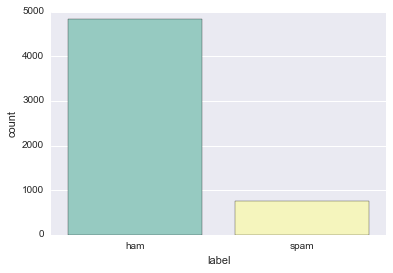

In [3]:
# print(messages)
print(messages.groupby('label').describe())
sns.countplot(x=messages['label'], data=messages, palette="Set3")

##### Выборка не сбалансирована. ham приблизительно в 6 раз больше, чем spam. Воспользуюсь грубым методом и разделю выборку на сеты одинаковой величины.. 

In [4]:
# messages['length'] = messages['message'].map(lambda text: len(text))
# print(messages.head())

### Сбалансирую данные

In [5]:
spam = messages[messages['label'] == 'spam']
ham = messages[messages['label'] == 'ham']

In [6]:
less_ham = ham.sample(n=len(spam))
balanced = pandas.concat([less_ham, spam])

## Сейчас я построю модели с той или иной нормализацией данных

In [10]:
bow_count = CountVectorizer()
bow_tfidf = TfidfVectorizer()

### Нормализовала данные: со знаками препинания. но! убрала штуки типа 'слово'+'..'

In [11]:
# 'слово'+'..'  плохо токенизируется функцией word_tokenize, поэтому уберем это
def tokenize(text):
    arr = [re.sub('(\w)\.\. ', '\\1 ', msg) for msg in text]
    return arr

In [13]:
bowed_messages = bow_count.fit_transform(tokenize(balanced['message']))
naive_model = MultinomialNB()
naive_model.fit(bowed_messages, balanced['label'])
cv_results = cross_val_score(naive_model, bowed_messages, balanced['label'], cv=10, scoring='accuracy')
print(cv_results.mean(), cv_results.std())

0.964558558559 0.0122454406079


In [14]:
predicted = cross_val_predict(naive_model, bowed_messages, balanced['label'], cv=10)
print(classification_report(balanced['label'], predicted))

             precision    recall  f1-score   support

        ham       0.95      0.98      0.97       747
       spam       0.98      0.95      0.96       747

avg / total       0.97      0.96      0.96      1494



### Нормализовала данные: без знаков препинания

In [15]:
def tokenize_no_punct(text):
    arr = [re.sub('[!"?/\\().:;,-]', '', msg) for msg in text]
    return arr

In [16]:
bowed_messages = bow_count.fit_transform(tokenize_no_punct(balanced['message']))
naive_model = MultinomialNB()
naive_model.fit(bowed_messages, balanced['label'])
cv_results = cross_val_score(naive_model, bowed_messages, balanced['label'], cv=10, scoring='accuracy')
print(cv_results.mean(), cv_results.std())

0.953189189189 0.0141990213325


In [17]:
predicted = cross_val_predict(naive_model, bowed_messages, balanced['label'], cv=10)
print(classification_report(balanced['label'], predicted))

             precision    recall  f1-score   support

        ham       0.94      0.97      0.95       747
       spam       0.97      0.93      0.95       747

avg / total       0.95      0.95      0.95      1494



### Нормализовала данные:

In [18]:
lancaster_stemmer = LancasterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()

### стемматизация

In [19]:
def tokenize_stem(text):
    text = [re.sub('(\w)\.\. ', '\\1 ', msg) for msg in text]
    text = [word_tokenize(msg) for msg in text]
    arr = []
    for msg in text:
        msg = [lancaster_stemmer.stem(i.lower()) for i in msg]
        arr.append(' '.join(msg))
    return arr

In [20]:
bowed_messages = bow_count.fit_transform(tokenize_stem(balanced['message']))
naive_model = MultinomialNB()
naive_model.fit(bowed_messages, balanced['label'])
cv_results = cross_val_score(naive_model, bowed_messages, balanced['label'], cv=10, scoring='accuracy')
print(cv_results.mean(), cv_results.std())

0.953810810811 0.0153993481585


In [21]:
predicted = cross_val_predict(naive_model, bowed_messages, balanced['label'], cv=10)
print(classification_report(balanced['label'], predicted))

             precision    recall  f1-score   support

        ham       0.94      0.97      0.95       747
       spam       0.97      0.93      0.95       747

avg / total       0.95      0.95      0.95      1494



### лемматизация

лемматайзер nltk тупо работает. по умолчанию он лемматизирует только существительные(((

In [22]:
def tokenize_lemma(text):
    text = [re.sub('(\w)\.\. ', '\\1 ', msg) for msg in text]
    text = [word_tokenize(msg) for msg in text]
    arr = []
    for msg in text:
        msg = [wordnet_lemmatizer.lemmatize(i.lower()) for i in msg]
        arr.append(' '.join(msg))
    return arr

In [23]:
bowed_messages = bow_count.fit_transform(tokenize_lemma(balanced['message']))
naive_model = MultinomialNB()
naive_model.fit(bowed_messages, balanced['label'])
cv_results = cross_val_score(naive_model, bowed_messages, balanced['label'], cv=10, scoring='accuracy')
print(cv_results.mean(), cv_results.std())

0.96054954955 0.0123603111128


In [24]:
predicted = cross_val_predict(naive_model, bowed_messages, balanced['label'], cv=10)
print(classification_report(balanced['label'], predicted))

             precision    recall  f1-score   support

        ham       0.95      0.98      0.96       747
       spam       0.98      0.95      0.96       747

avg / total       0.96      0.96      0.96      1494



### Нормализовала данные:  удаление стоп-слов

In [25]:
stopset = set(stopwords.words('english'))
def tokenize_stop(text):
    text = [re.sub('(\w)\.\. ', '\\1 ', msg) for msg in text]
    text = [[w for w in word_tokenize(msg) if not w in stopset] for msg in text]
    arr = []
    for msg in text:
        msg = [w for w in msg if not w in stopset]
        arr.append(' '.join(msg))
    return arr

In [26]:
bowed_messages = bow_count.fit_transform(tokenize_stop(balanced['message']))
naive_model = MultinomialNB()
naive_model.fit(bowed_messages, balanced['label'])
cv_results = cross_val_score(naive_model, bowed_messages, balanced['label'], cv=10, scoring='accuracy')
print(cv_results.mean(), cv_results.std())

0.957153153153 0.0091003656241


In [27]:
predicted = cross_val_predict(naive_model, bowed_messages, balanced['label'], cv=10)
print(classification_report(balanced['label'], predicted))

             precision    recall  f1-score   support

        ham       0.95      0.97      0.96       747
       spam       0.97      0.95      0.96       747

avg / total       0.96      0.96      0.96      1494



***модель без всяких улучшений типа лемматизации, удаления стоп-слов и т.п. показывает лучший результат. построим её же, только при помощи TfidfTransformer***

In [28]:
bowed_messages = bow_tfidf.fit_transform(tokenize(balanced['message']))
naive_model = MultinomialNB()
naive_model.fit(bowed_messages, balanced['label'])
cv_results = cross_val_score(naive_model, bowed_messages, balanced['label'], cv=10, scoring='accuracy')
print(cv_results.mean(), cv_results.std())

0.961891891892 0.0135899937886


In [29]:
predicted = cross_val_predict(naive_model, bowed_messages, balanced['label'], cv=10)
print(classification_report(balanced['label'], predicted))

             precision    recall  f1-score   support

        ham       0.95      0.97      0.96       747
       spam       0.97      0.95      0.96       747

avg / total       0.96      0.96      0.96      1494



### Результаты

1. Выборка не сбалансирована. ham приблизительно в 6 раз больше, чем spam. Так что попробуем поделить данные, вот.
2. Какой какой.. плохой очевидно 
3. разная токенизация (для простоты я смотрю на среднее значение, т.е. чем оно больше, тем лучше работает модель):
    * *все модели построены при помощи CountVectorizer*
        * **со знаками препинания:** mean: 0.962513513514    std: 0.0137901092475
        * **без знаков препинания:** mean: 0.955171171171    std: 0.0174874217089
        * **стемматизация + знаки препинания:** mean: 0.956531531532    std: 0.0179033400135
        * **лемматизация + знаки препинания:** mean: 0.960522522523    std: 0.0127876401246
        * **удаление стоп-слов:** mean: 0.955783783784    std: 0.0162463084155
    * *модель без всяких улучшений типа лемматизации, удаления стоп-слов и т.п. показывает лучший результат. построим её же, только при помощи TfidfTransformer*
        * **удаление стоп-слов:** mean: 0.96454954955 std: 0.0133338963845 ___TfidfTransformer работает лучше, чем CountVectorizer___

## Task 2

### Построю дерево решений

In [30]:
bowed_messages = bow_tfidf.fit_transform(tokenize(balanced['message']))

In [34]:
tree = DecisionTreeClassifier()
tree.fit(bowed_messages, balanced['label'])
cv_results = cross_val_score(tree, bowed_messages, balanced['label'], cv=10, scoring='accuracy')
print(cv_results.mean(), cv_results.std())

0.919027027027 0.0277580652399


In [35]:
predicted = cross_val_predict(tree, bowed_messages, balanced['label'], cv=10)
print(classification_report(balanced['label'], predicted))

             precision    recall  f1-score   support

        ham       0.90      0.93      0.91       747
       spam       0.92      0.90      0.91       747

avg / total       0.91      0.91      0.91      1494



фууууууу, дерево решений хуже всего работает(

### Построю RandomForest

In [36]:
bowed_messages = bow_tfidf.fit_transform(tokenize(balanced['message']))

In [37]:
forest = RandomForestClassifier()
forest.fit(bowed_messages, balanced['label'])
cv_results = cross_val_score(forest, bowed_messages, balanced['label'], cv=10, scoring='accuracy')
print(cv_results.mean(), cv_results.std())

0.939099099099 0.0164539135713


In [38]:
predicted = cross_val_predict(forest, bowed_messages, balanced['label'], cv=10)
print(classification_report(balanced['label'], predicted))

             precision    recall  f1-score   support

        ham       0.90      0.99      0.94       747
       spam       0.99      0.89      0.94       747

avg / total       0.95      0.94      0.94      1494



конечно, получше дерева решений, но всё равно хуже наивного байеса.

### Построю learning curve

In [39]:
from sklearn.model_selection import learning_curve

возьму функцию из тюториала

In [40]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a simple plot of the test and training learning curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 3-fold cross-validation,
          - integer, to specify the number of folds.
          - An object to be used as a cross-validation generator.
          - An iterable yielding train/test splits.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : integer, optional
        Number of jobs to run in parallel (default 1).
    """
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    return plt

In [41]:
bowed_messages = bow_tfidf.fit_transform(tokenize(balanced['message']))

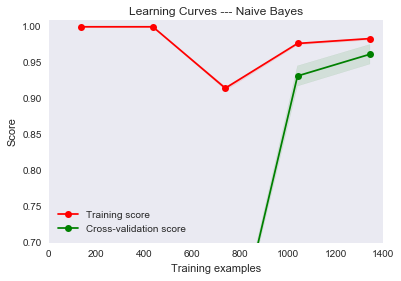

In [46]:
plot_learning_curve(naive_model, 'Learning Curves --- Naive Bayes', bowed_messages, balanced['label'], ylim=(0.7, 1.01), cv=10, n_jobs=4)
plt.show()

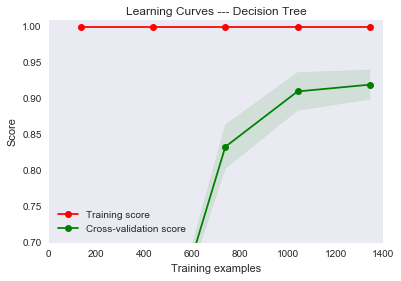

In [47]:
plot_learning_curve(tree, 'Learning Curves --- Decision Tree', bowed_messages, balanced['label'], ylim=(0.7, 1.01), cv=10, n_jobs=4)
plt.show()

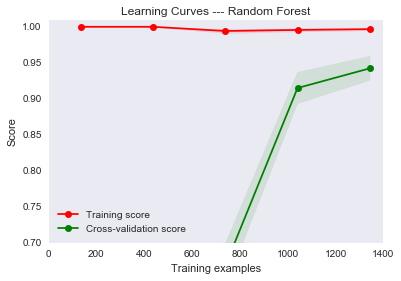

In [48]:
plot_learning_curve(forest, 'Learning Curves --- Random Forest', bowed_messages, balanced['label'], ylim=(0.7, 1.01), cv=10, n_jobs=4)
plt.show()